In [72]:
import spacy
import numpy as np
from collections import Counter, defaultdict
from word2number import w2n
import string, re, json
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import random
import pickle

In [2]:
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [3]:
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

def normalize_text(s):
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1) # remove '.' if it's not a decimal point

    def lower(text):
        return text.lower()
    
    def lemmatization(text):
        return " ".join([nlp(token)[0].lemma_ for token in text.split()])

    if len(s.strip()) == 1:
        # accept article and punc if input is a single char
        return white_space_fix(lower(s))
    elif len(s.strip().split()) == 1: 
        # accept article if input is a single word
        return lemmatization(white_space_fix(remove_punc(lower(s))))

    return lemmatization(white_space_fix(remove_articles(remove_punc(lower(s)))))

In [27]:
# VQA Eval (SQuAD style EM, F1)
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    bow_a = normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        bow_c = normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [48]:
guid2metrics = {}
beam = 5

for i in range(1, 11):
    split_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_binary_10_split/img_binary_split_{}.json".format(i), "r"))
    guids = [split_json[k]['Guid'] for k in split_json if split_json[k]['split'] == 'test']
    with open("/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/adv_split/split{}/qa_infr/test_qainfr_-1_beam5_img_True_True_step8_img_binary_split_{}.txt".format(i, i), "r") as f:
        lines = f.readlines()
    while True:
        if lines[0].strip() == "-----Starting writing results:-----":
            lines.pop(0)
            lines.pop(0)
            break
        else:
            lines.pop(0)

    pt = 'Q'
    
    folder = {'Q':[], 'A':[], 'C':[], 'TopC':[]}
    for l in lines:
        if pt == 'Q':
            folder[pt].append(l.strip())
            pt = 'A'
        elif pt == 'A':
            folder[pt].append(l.strip())
            pt = 'OC'
        elif pt == 'OC': # Output Confidence
            pt = 'C'
            folder[pt].append([])   
        elif pt == 'C':
            folder[pt][-1].append(l.strip())
            if len(folder[pt][-1]) == beam:
                folder['TopC'].append([folder[pt][-1][0]])
                pt = ''
        else:
            pt='Q' # skip empty line between samples
    assert len(folder['Q']) == len(folder['A']) == len(folder['C']) == len(folder['TopC']) == len(guids)
    
    for q, a, topc, guid in zip(folder['Q'], folder['A'], folder['TopC'], guids):
        F1_avg, F1_max, EM, RE, PR = compute_vqa_metrics(topc, a)
        if guid in guid2metrics:
            guid2metrics[guid]['F1'].append(F1_avg)
            guid2metrics[guid]['EM'].append(EM)
            guid2metrics[guid]['RE'].append(RE)
            guid2metrics[guid]['PR'].append(PR)
            guid2metrics[guid]['Q'].append(q)
            guid2metrics[guid]['A'].append(a)
            guid2metrics[guid]['C'].append(topc[0])
        else:
            guid2metrics[guid] = {'F1':[F1_avg], 'EM': [EM], 'RE': [RE], 'PR': [PR], 'Q': [q], 'A': [a], 'C': [topc[0]]}
    print(i, len(folder['Q']))


1 4186
2 4112
3 4024
4 4125
5 4100
6 4145
7 4093
8 4033
9 4156
10 4042


In [49]:
# pickle.dump(guid2metrics, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2metrics.pkl", "wb"))

# models are trained on 10 random splits (roughly 70%-30% train-test) for 8 epochs
# every guid shows up exactly 3 times in test set
# testing metrics for 10 random splits were generated and stored on Jun 29

In [50]:
guid2metrics = pickle.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2metrics.pkl", "rb"))
# sanity check
for guid in guid2metrics:
    for m in ['F1', 'EM', 'RE', 'PR']:
        if not len(guid2metrics[guid][m]) == 3:
            print(guid, m)

In [68]:
count = 0
hard_guids = []
for guid in guid2metrics:
    x = np.max(guid2metrics[guid]['F1'])
    if x == 0:
        hard_guids.append(guid)
        if random.random() < 0.005:
            print(guid, guid2metrics[guid]['F1'])
            print(guid2metrics[guid]['Q'][0])
            print(guid2metrics[guid]['A'])
            print(guid2metrics[guid]['C'])
            print()
        count += 1
print(len(hard_guids))

dc689bc0d46f11ebba07a504a20e7724 [0, 0, 0]
Are all of the crosswalks on Dickson Street in Fayetteville , Arkansas paved with brick ?
['Yes', 'Yes', 'Yes']
['No .', 'No', 'No .']

dc77d482d46f11ebba07a504a20e7724 [0, 0, 0]
Is the palm tree growing next to the Clock Tower on Worth Avenue taller than the clock tower ?
['yes', 'yes', 'yes']
['No', 'No', 'No']

dc7b7704d46f11ebba07a504a20e7724 [0, 0, 0]
Is the Schotten Busenborn Protestant Church Organ located on the ground floor ?
['No', 'No', 'No']
['Yes', 'Yes', 'Yes']

dc64e066d46f11ebba07a504a20e7724 [0, 0, 0]
Do the Laughing Falcon and the Lesser Spotted Woodpecker both have black beaks ?
['Yes', 'Yes', 'Yes']
['No', 'No .', 'No']

dc456e16d46f11ebba07a504a20e7724 [0, 0, 0]
Does the Bethesda fountain run ?
['Yes', 'Yes', 'Yes']
['no', 'No .', 'No']

dc578dd0d46f11ebba07a504a20e7724 [0, 0, 0]
At the Navy Pier in Chicago , which item is shorter , the Ferris wheel or the chair swing ride ?
['the chair swing ride', 'the chair swing ride',

In [74]:
# pickle.dump(hard_guids, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/YesNo_choose_ood_guid.pkl", "wb"))

# every guid shows up 3 times in test set out of 10 random splits.
# guids that got zero F1 for all 3 times are put into adversarial bucket
# ood guids for YesNo and choose categories were generated on Jun 29

In [82]:
count = 0
F1means = []
F1maxs = []
F1mins = []
for guid in guid2metrics:
    x = np.mean(guid2metrics[guid]['F1'])
    F1means.append(x)
    F1mins.append(np.min(guid2metrics[guid]['F1']))
    F1maxs.append(np.max(guid2metrics[guid]['F1']))
    if x  == 0:
        count += 1
print(count)

2129


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


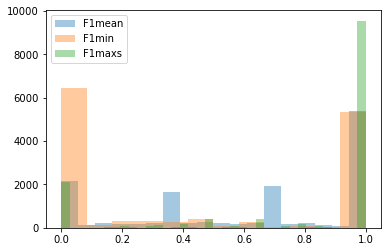

In [83]:
sns.distplot(F1means, kde=False, label="F1mean")
sns.distplot(F1mins, kde=False, label="F1min")
sns.distplot(F1maxs, kde=False, label="F1maxs")

plt.legend()

In [70]:
# Sanity check after img_dataset_J_Qcate.json is fixed
dataset_J_Qcate = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_Qcate.json", "r"))
print(Counter([dataset_J_Qcate[k]['Qcate'] for k in dataset_J_Qcate]))
print(len(set([dataset_J_Qcate[k]['Guid'] for k in dataset_J_Qcate])))
print(Counter([len(dataset_J_Qcate[j]['GoldIds']) for j in dataset_J_Qcate]))
print([k for k in range(25474) if str(k) not in dataset_J_Qcate])

Counter({'YesNo': 8432, 'Others': 6748, 'choose': 5240, 'number': 2341, 'color': 2044, 'shape': 662})
25467
Counter({1: 14337, 2: 11130})
[233, 338, 443, 1233, 1234, 2141, 2361]


In [75]:
cate = defaultdict(int)
for k in dataset_J_Qcate:
    if dataset_J_Qcate[k]['Guid'] in hard_guids:
        cate[dataset_J_Qcate[k]['Qtype']] += 1
pprint(cate)

defaultdict(<class 'int'>, {'img-Singlehop': 984, 'img-Multihop': 1145})
